Paper link: https://ojs.aaai.org/index.php/AAAI/article/download/17067/16874

Authors: Zhaojing Luo, Shaofeng Cai, Can Cui, Beng Chin Ooi, Yang Yang
    



# Adaptive Knowledge Driven Regularization for Deep Neural Networks

## Introduction

### Import the Modules

In [1]:
import matplotlib.pyplot as plt # For plotting
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from library.models import * # contains networks that are used in training
from library.loss import *  # contains loss calculation functions
from metrics.metric import * # contains metric calculation functions
from library.dataset import * # contains dataset classes
from library.data_structure import * # contains enums 
from library.regularizer import * # OUR REGULARIZER CLASS
import warnings
import sys
warnings.filterwarnings("ignore")
# It automatically reloads your modules whenever
%load_ext autoreload
%autoreload 2


### Hyperparameters

In [2]:
# Data Sizes
batch_size = 128
image_size = 256 
mnist_ae_size = 28
mnist_lenet_size = 32
sentence_polarity_sequence_length = 25 # given from paper

# Optimizer and Device Setup
sgd_optimizer_momentum = 0.9
seed = 0  # manual seed
device = 'cuda' 

# Regularizer variables
drop_out_probability = 0.6
maxnorm_maximum_val = 5

# Out Sizes
mnist_out_size = 10
polarity_out_size = 2

# Hidden Sizes
# MLP
mlp_hidden_size = 128

# LSTM
lstm_number_of_layer = 2
lstm_hidden_size = 128

### Device Setup

In [3]:
# Select training device
device = torch.device(device if (torch.cuda.is_available()) else 'cpu')

# Seed for reproducibility
torch.manual_seed(seed)

### Helper Function for Plotting

In [4]:

# Plot the Table for Performance Comparison (Table 2 and Table 3 in the Paper)
def plot_performance_table(results, model_name, metric_type, no_of_decimal_points_to_show = 4):
    
    # Adjust Table Position
    plt.subplots_adjust(left=0.2, top=0.6)
    
    # Determine Columns and the Rows(also colors)
    col_labels = ([str(x)  for x in results.keys()])
    col_labels.insert(0, "Metric")
    row_labels = [model_name]
    row_colors = np.full(len(row_labels), '#7AC5CD')
    col_colors = np.full(len(col_labels), '#FFD39B')

    # Axis Specification 
    plt.axis('off')
    plt.axis('tight')

    # Fill the data array 
    data = [[str( round(x, no_of_decimal_points_to_show)) for x in results.values()]]
    
    # Add metric type
    for i in range(len(data)):
        data[i].insert(0,metric_type)

    # Plot the Table
    table = plt.table(cellText=data,
              rowLabels=row_labels,
              rowColours=row_colors,
              colColours=col_colors,
              colLabels=col_labels,
              loc='best')

    table.scale(2, 3) 
    plt.title('Performance Comparison Table', x=0.1 , fontweight="bold")
    plt.plot()
    plt.show()
    
# Plot Average VPR Table (Table 4 in the paper) 
def plot_vpr_table(avg_top_item, avg_bottom_item, dist_avg_item, model_name, layers):
    plt.subplots_adjust(left=0.2, top=0.6)

    # Determine Columns and the Rows(also colors)
    col_labels = (['Bottom Avg VPR', 'Top Avg VPR', 'Avg VPR Dist'])
    row_labels = [model_name + '-' + str(l) for l in layers]

    row_colors = np.full(len(row_labels), '#7AC5CD')
    col_colors = np.full(len(col_labels), '#FFD39B')

    # Axis Specification 
    plt.axis('off')
    plt.axis('tight')
    
    # Fill the data array with VPR values
    data = np.zeros((len(avg_bottom_item.keys()),3))
    for i,(key_top,key_bot,key_dist) in enumerate(zip(avg_top_item.keys(),avg_bottom_item.keys(),dist_avg_item.keys())):
        data[i][1] = avg_top_item[key_top]
        data[i][0] = avg_bottom_item[key_bot]
        data[i][2] = dist_avg_item[key_dist]
    
    # Plot the Table    
    table = plt.table(cellText=data,
              rowLabels=row_labels,
              rowColours=row_colors,
              colColours=col_colors,
              colLabels=col_labels,
              loc='best')
    
    table.scale(2, 3) 
    plt.title('Average VPR for bottom and top model parameters', x=0.1, fontweight="bold")
    plt.plot()
    plt.show()
    
# Plot VPR percentage figure (Figure 2 in the paper)
def plot_vpr_figure(number_of_top_item, number_of_bottom_item, model_name):
    # Determine the x axis 
    x = np.linspace(0.05, 1, 20)
    
    # Plot the Figure with percentage of bottom model and top model
    plt.plot(x, number_of_top_item, color='green', linewidth = 3,
             marker='o', markerfacecolor='blue',label='Top Item', markersize=5)

    plt.plot(x, number_of_bottom_item, color='orange', linewidth = 3,
             marker='o', markerfacecolor='red',label='Bottom Item', markersize=5)
    
    # Set The Title and axis labels
    plt.xlabel('VPR')
    plt.ylabel('Percentage')
    plt.title("The Distribution of Parameters - " + model_name, fontweight="bold")
    plt.legend()
    plt.show()
    
# Plot the table of t ratio (Table 1)    
def plot_t_ratio_table(t_ratio, model_name, layers):
    plt.subplots_adjust(left=0.2, top=0.6)

    # Determine Columns and the Rows(also colors)
    epochs = [0.25,0.5,0.75,1]
    col_labels = (['25% Epoch', '50% Epoch', '75% Epoch','100% Epoch'])
    row_labels = [model_name + '-' + str(l) for l in layers]
    row_colors = np.full(len(row_labels), '#7AC5CD')
    col_colors = np.full(len(col_labels), '#FFD39B')

    # Axis Specification
    plt.axis('off')
    plt.axis('tight')
    
    # Fill the data array with VPR values
    data = np.zeros((len(layers),4))
    for i,(lyr) in enumerate(layers):
        for j, epoch in enumerate(epochs):
            if  (epoch,lyr) in t_ratio:
                data[i][j] = t_ratio[epoch,lyr]
            else:
                data[i][j] = 0
                
    # Plot the Table    
    table = plt.table(cellText=data,
              rowLabels=row_labels,
              rowColours=row_colors,
              colColours=col_colors,
              colLabels=col_labels,
              loc='best')

    table.scale(2, 3) 
    plt.title('Ratio of pairs of neurons with t-values exceeding the critical values.', x=0.1, fontweight="bold")
    plt.plot()
    plt.show()
    
# Plot the hyperparameter Effectiveness (Figure 3)    
def plot_effectiveness_figure(results, beta, model_name, metrics):
#     max_y = 0
#     min_y = 100000000000000
    for i in range(len(results)):
        # Randomly choose colors
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        marker_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        lambda_reg,y = [], []
        
        # Fill data with metric score
        for key, val in results[i].items():
            lambda_reg.append(key)
            y.append(val)
#             if val > max_y:
#                 max_y = val
#             if val < min_y:
#                 min_y = val
        
        # Plot the Table
        plt.plot(lambda_reg, y, color=color[0], linewidth=3,
            marker='o', markerfacecolor=marker_color[0],label=str(beta[i]), markersize=5)
    #plt.ylim(min_y-5, max_y +5)
    plt.xscale('log')
    plt.xlabel('Hyperparam. Lambda')
    plt.ylabel(metrics)
    plt.title(model_name, fontweight="bold")
    plt.legend()
    plt.show()
    
    

### Load Datasets

#### MNIST Dataset & DataLoader


In [5]:
# Dataset class in library.dataset 

# MNIST-28 is used in MLP and AE Training
mnist_28 = MNIST_Dataset(is_image_2d = False, img_size=mnist_ae_size)
mnist_28_train_data = mnist_28.get_train_dataset()
mnist_28_test_data = mnist_28.get_test_dataset()

# Loading a MNIST-28 Dataset 
mnist_28_train_loader = DataLoader(mnist_28_train_data, shuffle = True, batch_size=batch_size)
mnist_28_test_loader = DataLoader(mnist_28_test_data, shuffle = True, batch_size=batch_size)

# MNIST-32 is used in LeNet Training
mnist_32 = MNIST_Dataset(is_image_2d = True, img_size=mnist_lenet_size)
mnist_32_train_data = mnist_32.get_train_dataset()
mnist_32_test_data = mnist_32.get_test_dataset()

# Loading a MNIST-32 Dataset 
mnist_32_train_loader = DataLoader(mnist_32_train_data, shuffle = True, batch_size=batch_size)
mnist_32_test_loader = DataLoader(mnist_32_test_data, shuffle = True, batch_size=batch_size)

print("Length of MNIST Train Dataset: " + str(len(mnist_28_train_data)))
print("Length of MNIST Test Dataset: " + str(len(mnist_28_test_data)))


Length of MNIST Train Dataset: 60000
Length of MNIST Test Dataset: 10000


#### CIFAR10 Dataset & DataLoader

In [6]:
# CIFAR_10_Dataset is used in VGG Training
cifar_10 = CIFAR_10_Dataset()
cifar_10_train_data = cifar_10.get_train_dataset()
cifar_10_test_data = cifar_10.get_test_dataset()

# Loading a CIFAR_10 Dataset 
cifar_10_train_loader = DataLoader(cifar_10_train_data, shuffle = True, batch_size = batch_size)
cifar_10_test_loader = DataLoader(cifar_10_test_data, shuffle = True, batch_size = batch_size)

print("Length of CIFAR10 Train Dataset: " + str(len(cifar_10_train_data)))
print("Length of CIFAR10 Test Dataset: " + str(len(cifar_10_test_data)))

Files already downloaded and verified
Files already downloaded and verified
Length of CIFAR10 Train Dataset: 50000
Length of CIFAR10 Test Dataset: 10000


#### Sentence Polarity Dataset & DataLoader

Please use download_data.sh script to download Sentence Polarity dataset.

In [7]:
# Dataset class in library.dataset 

# Sentence Polarity Dataset is used in LSTM, MLP Training
sentence_polarity_dataset = Sentence_Polarity_Dataset("dataset/rt-polarity.pos", "dataset/rt-polarity.neg")
sentence, label = sentence_polarity_dataset.get_data()

# Split train and test data 
p_sentence_train, p_sentence_test, p_label_train, p_label_test = train_test_split(sentence, label, stratify=label)

# Match word to number and create vocabulary table based on the data (util.py)
p_sentence_train, p_label_train, p_sentence_test, p_label_test, sentence_vocab_length = preprocess_data(p_sentence_train,
                                                                                                        p_label_train, 
                                                                                                        p_sentence_test,
                                                                                                        p_label_test)

# Set input sequence length (util.py)
p_sentence_train = padding(p_sentence_train, sentence_polarity_sequence_length)
p_sentence_test = padding(p_sentence_test, sentence_polarity_sequence_length)

# Tensor datasets
sentence_p_train_data = TensorDataset(torch.from_numpy(p_sentence_train), torch.from_numpy(p_label_train))
sentence_p_test_data = TensorDataset(torch.from_numpy(p_sentence_test), torch.from_numpy(p_label_test))

print("Length of Sentence Polarity Train Dataset: " + str(len(p_sentence_train)))
print("Length of Sentence Polarity Test Dataset: " + str(len(p_sentence_test)))

# Loading a Sentence Polarity Dataset
polarity_train_loader = DataLoader(sentence_p_train_data, shuffle=True, batch_size=batch_size)
polarity_test_loader = DataLoader(sentence_p_test_data, shuffle=True, batch_size=batch_size)

Length of Sentence Polarity Train Dataset: 7996
Length of Sentence Polarity Test Dataset: 2666


### Models  Initialization

In [8]:
# MLPType, NetworkType enums are defined in library/data_structure.py
# Model Classes are defined in library/model.py

def init_model(network_type, input_dim = 128, hidden_dim = 128, out_dim = 10, mlp_type = None, 
               dropout=(False,0.3), lstm_number_of_layer = 2, device='cuda'):
    
    #   :param: network_type: the model class name
    #   :param: input_dim: input dimension of network
    #   :param: hidden_dim: hidden dimension of network
    #   :param: out_dim: output dimension of network
    #   :param: mlp_type: the dataset that is used in MLP if class name specied as MLP
    #   :param: dropout: dropout usage situation and the probability
    #   :param: lstm_number_of_layer: the number of LSTM layer
    #   :param: device: training device

    
    # Initalize model that will be trained
    if network_type == NetworkType.LSTM:
        model = LSTM(input_dim, hidden_dim, out_dim, lstm_number_of_layer,device, dropout=dropout)
        return model
    
    elif network_type == NetworkType.MLP:
        if mlp_type == MLPType.Polarity:
            model = MLP(MLPType.Polarity, input_dim, hidden_dim, out_dim,dropout=dropout)
            return model
        
        elif mlp_type == MLPType.MNIST:
            model = MLP(MLPType.MNIST,input_dim, hidden_dim, out_dim, dropout=dropout)
            return model
        
    elif network_type == NetworkType.LeNet:
        model = LeNet5(out_dim, dropout=dropout)
        return model
    
    elif network_type == NetworkType.AE:
        model = AE(dropout=dropout)
        return model
    
    elif network_type == NetworkType.VGG:
        model = VGG(dropout=dropout)
        return model
    

### Training & Testing

#### L1&L2 Regularization Calculation

In [9]:
# L2 regularization 
def calc_L2_reg(weight):
    return weight.pow(2).sum()

# L1 regularization 
def calc_L1_reg(weight):
    return weight.abs().sum()

#### Lazy Update (Algorithm 1)

In [10]:
# Lazy Update Function (Algorith 1 in the paper)

def regularize_params(model, regularizer, regularizer_type, activation_val_of_layers, 
                      epoch_no, total_epoch, device, vpr_tested = False):
    
    #   :param: model: the model that is under training
    #   :param: regularizer: CorrReg regularizer object
    #   :param: regularizer_type: The type of the regularizer (L1,L2 or CorrReg)
    #   :param: activation_val_of_layers: Activation value of layers 
    #   :param: epoch_no: the current epoch no
    #   :param: total_epoch: total no of epoch
    #   :param: device: training device
    #   :param: vpr_tested: boolean value to calculate vpr or not
    
    i, reg_loss = 0, 0.0
    weight = []
    
    # E is the number of the first few epochs without lazy update
    # Ts is the update interval for updating significance weights
    correg_E = 3
    correg_Ts = 10
    
    if regularizer_type == RegularizerType.CorrReg:    
        # Calculate Regularization Loss(Derived From Equation 6 in the paper)     
        i = 0    
        for model_param_name, model_param_value in model.named_parameters():
            if 'weight' in model_param_name and regularizer.regularized_param_name in model_param_name:
                i += 1
                if i > 1:
                    reg_loss += regularizer.lambda_reg * regularizer.calc_Corr_reg(model_param_value, 
                                                                                   regularizer.theta[i - 2],
                                                                                   device)
                    weight.append(abs(model_param_value))
                    
        # Check Epochs Before Updating Significance Weights
        # Update Significance Weights (Equation 8)
        if epoch_no < correg_E or epoch_no % correg_Ts == 0:
            regularizer.update_theta(model, activation_val_of_layers)

        # Calculate CPR & VPR in the last epoch, if the boolean value is set to True             
        if epoch_no == total_epoch and vpr_tested is True:
            regularizer.compute_cpr()
            regularizer.compute_vpr(weight)
            
    # Calculate L2 regularization value
    elif regularizer_type == RegularizerType.L2:
        for model_param_name, model_param_value in model.named_parameters():
            if 'weight' in model_param_name:
                reg_loss += regularizer.lambda_reg * calc_L2_reg(model_param_value)
                
    # Calculate L1 regularization value
    elif regularizer_type == RegularizerType.L1:
        for model_param_name, model_param_value in model.named_parameters():
            if 'weight' in model_param_name:
                reg_loss += regularizer.lambda_reg * calc_L1_reg(model_param_value)
    return reg_loss



#### Test Function (t values and VPR&CPR calculation)

In [11]:
# Calculating t-values of correlations

def calculate_t_values(regularizer, epoch_no, total_epoch): 
    regularizer.calculate_ratio_of_t_values(epoch_no/total_epoch)

#### Training Loop

In [12]:
# Training Loop
# The testing values such as t values & VPR & CPR are also calculated here!!!

def train(model, optimizer, train_loader,test_loader, total_epoch, regularizer_type, 
          metric_type, regularizer, device, loss_type=LossType.NLLoss, 
          maxnorm_maximum_val = 3, activation_names = None, t_value_tested = False, vpr_tested = False):
    
    # Initialize the Metric Calculator 
    metric = MetricCalculator()
    loss_history = []
    
    # Load model to device
    model.to(device)
    
    # Initialize Significance Weights if the CorrReg is chosen as regularizer
    if regularizer_type == RegularizerType.CorrReg:
        regularizer.init_theta(model)
        
    for epoch in range(total_epoch):
        model.train()
        for i, (input_batch, label_batch) in enumerate(train_loader):
            
            # Load batches data to device
            input_batch = input_batch.to(device)
            label_batch = label_batch.to(device)
            
            # Run the model
            out_batch = model(input_batch)

            # Calculate Loss (MSE or NLL loss)
            if loss_type == LossType.NLLoss:
                loss = calc_nll_loss(label_batch, out_batch)
            else:
                loss = calc_mse_loss(out_batch, input_batch)
                
            
                                   # Regularize the Model #
            #######################################################################
            # Regularizer for L1, L2 and CorrReg
            reg_loss = regularize_params(model, regularizer, regularizer_type, activation_names, 
                                         epoch + 1, total_epoch, device = device, vpr_tested = vpr_tested)
            loss += reg_loss
            
            # Regularizer for Max Norm
            if regularizer_type == RegularizerType.MaxNorm:
                for name, param in model.named_parameters():
                    if 'bias' not in name:
                        norm = param.norm(maxnorm_maximum_val, dim=0, keepdim=True)
                        desired = torch.clamp(norm, 0, 3)
                        param.data = param.data * (desired / (1e-8 + norm))
           #########################################################################
                               
            loss_history.append(loss.item())
            
            # Backpropagation   
            model.zero_grad()
            loss.backward()
            optimizer.step()            
            torch.cuda.empty_cache()

        # Calculate T value while Regularization Type is CorrRef and the boolean value is set to True
        # Only the ratio of current_epoch/total_epoch is 25% or 50% or 75% or 100% 
        if regularizer_type == RegularizerType.CorrReg and t_value_tested is True:
            if ((abs(((epoch+1)/total_epoch)-0.25) < sys.float_info.epsilon) or
                (abs(((epoch+1)/total_epoch)-0.5) < sys.float_info.epsilon) or
                (abs(((epoch+1)/total_epoch)-0.75) < sys.float_info.epsilon) or
                (abs(((epoch+1)/total_epoch)-1.0) < sys.float_info.epsilon)):
                
                #Initialize t value of correlations
                regularizer.init_t_values()
                
                # Test the all data while model is in eval mode
                for i, (input_batch, label_batch) in enumerate(train_loader):
                    with torch.no_grad():
                        model.eval()
                        input_batch = input_batch.to(device)
                        out_batch = model(input_batch)
                        _ = regularizer.update_theta(model, activation_names, is_t_value_tested=True)
                        
                # Calculating the t value of correlations
                calculate_t_values(regularizer, epoch+1, total_epoch) 
    
                
    # Calculate Metric Score in Test Dataset
    for i, (input_batch, label_batch) in enumerate(test_loader):
        with torch.no_grad():
            model.eval()
            input_batch = input_batch.to(device)
            label_batch = label_batch.to(device)
            out_batch = model(input_batch)
            
            # Calculate Score
            metric_score = metric.calc_metric_score(metric_type,input_batch, label_batch, out_batch)
            
    return loss_history, metric_score


# Experiments

### Polarity-LSTM

Polarity-LSTM with CorrReg network is being started...
Polarity-LSTM with L1 network is being started...
Polarity-LSTM with L2 network is being started...
Polarity-LSTM with Dropout network is being started...
Polarity-LSTM with Maxnorm network is being started...


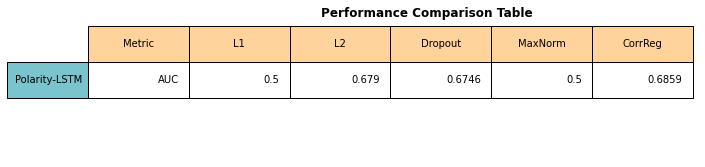

In [91]:
## LSTM Results Dictionary
lstm_polarity_metric_results =  {
    "L1" : 0,
    "L2" : 0,
    "Dropout" : 0,
    "MaxNorm" : 0,
    "CorrReg" : 0
}


num_epochs = 20
learning_rate = 0.1
lambda_reg = 5e-4
beta_reg = 1e-7
drop_out_probability = 0.75
maxnorm_maximum_val = 2

# Regularizer Initialization & LSTM Initialization 
regularizer = Regularizer(lambda_reg = lambda_reg, beta_reg = beta_reg)
model = init_model(NetworkType.LSTM, sentence_vocab_length, lstm_hidden_size, 
                   out_dim = polarity_out_size,
                   lstm_number_of_layer = lstm_number_of_layer,
                   device = device)

# Register Activation Layer 
activation_layers_names = []
for name, layer in model.named_modules():
    if 'hidden' in name: 
        layer.register_forward_hook(get_activation(name))
        activation_layers_names.append(name)
        
#########################################################################################################
######################### Polarity-LSTM with CorrReg Training ###########################################
#########################################################################################################

print("Polarity-LSTM with CorrReg network is being started...")
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, lstm_polarity_metric_results["CorrReg"] = train(model,optimizer, polarity_train_loader,
                                                   polarity_test_loader, num_epochs,
                                                   RegularizerType.CorrReg, MetricType.AUC, 
                                                   regularizer, device,
                                                   activation_names = activation_layers_names)



#########################################################################################################
######################### Polarity-LSTM with L1 Training ################################################
#########################################################################################################

print("Polarity-LSTM with L1 network is being started...")
model = init_model(NetworkType.LSTM, sentence_vocab_length, lstm_hidden_size, 
                   out_dim = polarity_out_size, lstm_number_of_layer = lstm_number_of_layer,
                   device = device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
train_history, lstm_polarity_metric_results["L1"] = train(model,optimizer, polarity_train_loader, 
                                                          polarity_test_loader, num_epochs,
                                                          RegularizerType.L1, MetricType.AUC, 
                                                          regularizer, device)


#########################################################################################################
######################### Polarity-LSTM with L2 Training ################################################
#########################################################################################################

# Polarity-LSTM with L2 Training 
print("Polarity-LSTM with L2 network is being started...")
model = init_model(NetworkType.LSTM, sentence_vocab_length, lstm_hidden_size,
                   out_dim = polarity_out_size,
                   lstm_number_of_layer = lstm_number_of_layer,
                   device = device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
train_history, lstm_polarity_metric_results["L2"] = train(model,optimizer, 
                                                          polarity_train_loader, polarity_test_loader,
                                                          num_epochs,RegularizerType.L2, MetricType.AUC,
                                                          regularizer, device)


#########################################################################################################
######################### Polarity-LSTM with Dropout Training ###########################################
#########################################################################################################

# Polarity-LSTM with Dropout Training 
print("Polarity-LSTM with Dropout network is being started...")
model = init_model(NetworkType.LSTM, sentence_vocab_length, lstm_hidden_size, 
                   out_dim = polarity_out_size,
                   dropout = (True, drop_out_probability),
                   lstm_number_of_layer = lstm_number_of_layer,
                   device = device)
 
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
train_history, lstm_polarity_metric_results["Dropout"] = train(model,optimizer, polarity_train_loader, 
                                                               polarity_test_loader,num_epochs,
                                                               RegularizerType.Dropout, MetricType.AUC, 
                                                               regularizer, device)


#########################################################################################################
######################### Polarity-LSTM with Maxnorm Training ###########################################
#########################################################################################################
# Polarity-LSTM with Maxnorm Training 
print("Polarity-LSTM with Maxnorm network is being started...") 
model = init_model(NetworkType.LSTM, sentence_vocab_length, lstm_hidden_size, 
                   out_dim = polarity_out_size,
                   lstm_number_of_layer = lstm_number_of_layer,
                   device = device)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
train_history, lstm_polarity_metric_results["MaxNorm"] = train(model,optimizer, 
                                                               polarity_train_loader, 
                                                               polarity_test_loader,num_epochs,
                                                               RegularizerType.MaxNorm, MetricType.AUC, 
                                                               regularizer, device,
                                                               maxnorm_maximum_val = maxnorm_maximum_val)


#########################################################################################################
########################### Plotting Comparison Table ###################################################
#########################################################################################################


plot_performance_table(lstm_polarity_metric_results, "Polarity-LSTM", "AUC")

### Polarity-MLP

#### CORR-Reg, L1, L2, Dropout, MaxNorm

Polarity-MLP with CorrReg network is being started...
Polarity-MLP with L1 network is being started...
Polarity-MLP with L2 network is being started...
Polarity-MLP with Dropout network is being started...
Polarity-MLP with MaxNorm network is being started...


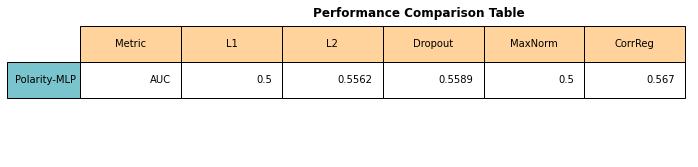

In [92]:
# MLP Polarity Results Dictionary 
mlp_polarity_metric_results =  {
    "L1" : 0,
    "L2" : 0,
    "Dropout" : 0,
    "MaxNorm" : 0,
    "CorrReg" : 0
}

# Hyperparameter of Polarity-MLP Training
num_epochs = 50
learning_rate = 0.1
lambda_reg = 1e-3
beta_reg = 1e-6
drop_out_probability = 0.6
maxnorm_maximum_val = 1

# Regularizer Initialization & MLP Initialization 
regularizer = Regularizer(lambda_reg = lambda_reg, beta_reg = beta_reg)
model = init_model(NetworkType.MLP, sentence_vocab_length, 
                   mlp_hidden_size, out_dim = polarity_out_size, 
                   mlp_type = MLPType.Polarity)

# Register Activation Layer 
activation_layers_names = []
for name, layer in model.named_modules():
    if 'hidden' in name: 
        layer.register_forward_hook(get_activation(name))
        activation_layers_names.append(name)
        
#####################################################################################################
######################### Polarity-MLP with CorrReg Training ########################################
#####################################################################################################

print("Polarity-MLP with CorrReg network is being started...")
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, mlp_polarity_metric_results["CorrReg"] = train(model,optimizer, 
                                                  polarity_train_loader, polarity_test_loader, 
                                                  num_epochs, RegularizerType.CorrReg, MetricType.AUC, 
                                                  regularizer, device,
                                                  activation_names = activation_layers_names)

#####################################################################################################
######################### Polarity-MLP with L1 Training #############################################
#####################################################################################################

print("Polarity-MLP with L1 network is being started...")
model = init_model(NetworkType.MLP, sentence_vocab_length, mlp_hidden_size, 
                   out_dim=polarity_out_size,
                   mlp_type=MLPType.Polarity)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, mlp_polarity_metric_results["L1"] = train(model,optimizer, polarity_train_loader, 
                                             polarity_test_loader, num_epochs,RegularizerType.L1, 
                                             MetricType.AUC, regularizer, device)

#####################################################################################################
######################### Polarity-MLP with L2 Training #############################################
#####################################################################################################

print("Polarity-MLP with L2 network is being started...")
model = init_model(NetworkType.MLP, sentence_vocab_length, mlp_hidden_size, 
                   out_dim = polarity_out_size,
                   mlp_type = MLPType.Polarity)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, mlp_polarity_metric_results["L2"] = train(model,optimizer, polarity_train_loader, 
                                             polarity_test_loader, num_epochs,RegularizerType.L2,
                                             MetricType.AUC, regularizer, device)


#####################################################################################################
######################### Polarity-MLP with Dropout Training ########################################
#####################################################################################################

print("Polarity-MLP with Dropout network is being started...")
model = init_model(NetworkType.MLP, sentence_vocab_length, mlp_hidden_size, 
                   out_dim = polarity_out_size, mlp_type = MLPType.Polarity,
                   dropout=(True, drop_out_probability))

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, mlp_polarity_metric_results["Dropout"] = train(model,optimizer, polarity_train_loader, 
                                                  polarity_test_loader, num_epochs,
                                                  RegularizerType.Dropout, MetricType.AUC, 
                                                  regularizer, device)

#####################################################################################################
######################### Polarity-MLP with MaxNorm Training ########################################
#####################################################################################################

print("Polarity-MLP with MaxNorm network is being started...")
model = init_model(NetworkType.MLP, sentence_vocab_length, mlp_hidden_size, 
                   out_dim = polarity_out_size, 
                   mlp_type = MLPType.Polarity)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, mlp_polarity_metric_results["MaxNorm"] = train(model,optimizer, polarity_train_loader, 
                                                  polarity_test_loader, num_epochs,
                                                  RegularizerType.MaxNorm, MetricType.AUC,
                                                  regularizer, device,
                                                  maxnorm_maximum_val = maxnorm_maximum_val)
#########################################################################################################
########################### Plotting Comparison Table ###################################################
#########################################################################################################
plot_performance_table(mlp_polarity_metric_results, "Polarity-MLP", "AUC")

### Mnist-MLP

#### CORR-Reg, L1, L2, Dropout, MaxNorm

MNIST-MLP with CorrReg network is being started...
MNIST-MLP with L1 network is being started...
MNIST-MLP with L2 network is being started...
MNIST-MLP with Dropout network is being started...
MNIST-MLP with MaxNorm network is being started...


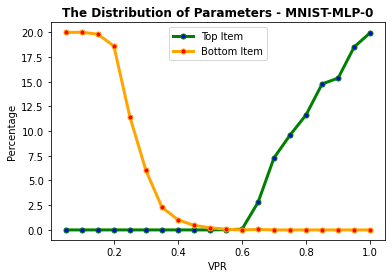

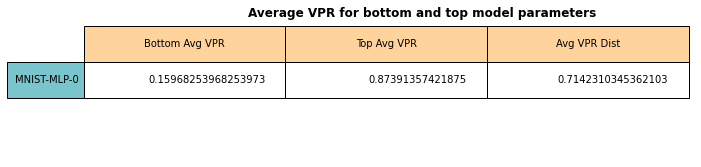

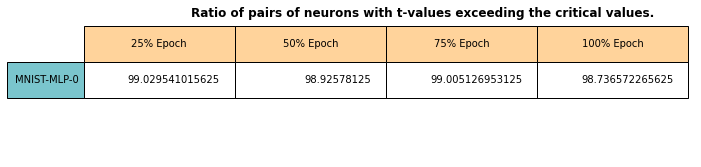

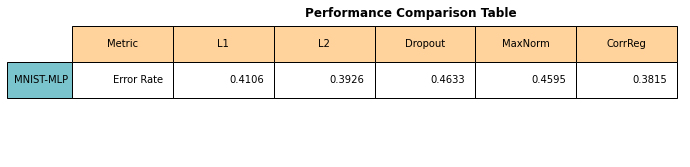

In [93]:
# MNIST MLP Results Dictionary 
mlp_mnist_metrics_result =  {
    "L1" : 0,
    "L2" : 0,
    "Dropout" : 0,
    "MaxNorm" : 0,
    "CorrReg" : 0
}

# Hyperparameter of MNIST-MLP Training
num_epochs = 12
learning_rate = 0.005
lambda_reg = 0.0001
beta_reg = 1e-6
maxnorm_maximum_val = 1
drop_out_probability = 0.6

# Regularizer Initialization & MLP Initialization 
regularizer = Regularizer(lambda_reg = lambda_reg, beta_reg = beta_reg)
model = init_model(NetworkType.MLP,  mnist_ae_size * mnist_ae_size, 
                   mlp_hidden_size, out_dim = mnist_out_size,
                   mlp_type = MLPType.MNIST)

# Register Activation Layer 
activation_layers_names = []
for name, layer in model.named_modules():
    if 'hidden' in name: 
        layer.register_forward_hook(get_activation(name))
        activation_layers_names.append(name)

#####################################################################################################
######################### MNIST-MLP with CorrReg Training ###########################################
#####################################################################################################

# MNIST-MLP with CorrReg
print("MNIST-MLP with CorrReg network is being started...")
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, mlp_mnist_metrics_result["CorrReg"] = train(model,optimizer, mnist_28_train_loader,
                                               mnist_28_test_loader, num_epochs, RegularizerType.CorrReg,
                                               MetricType.Error_Rate, 
                                               regularizer, device,
                                               activation_names = activation_layers_names,
                                               t_value_tested = True ,vpr_tested = True)


#####################################################################################################
######################### MNIST-MLP with L1 Training ################################################
#####################################################################################################

print("MNIST-MLP with L1 network is being started...")
model = init_model(NetworkType.MLP, mnist_ae_size * mnist_ae_size, mlp_hidden_size,
                   out_dim = mnist_out_size,mlp_type = MLPType.MNIST)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, mlp_mnist_metrics_result["L1"] = train(model,optimizer, mnist_28_train_loader, 
                                          mnist_28_test_loader, num_epochs,RegularizerType.L1, 
                                          MetricType.Error_Rate,regularizer, device)


#####################################################################################################
######################### MNIST-MLP with L2 Training ################################################
#####################################################################################################

print("MNIST-MLP with L2 network is being started...")
model = init_model(NetworkType.MLP, mnist_ae_size*mnist_ae_size, mlp_hidden_size, 
                   out_dim = mnist_out_size,
                   mlp_type = MLPType.MNIST)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)

_, mlp_mnist_metrics_result["L2"] = train(model,optimizer, mnist_28_train_loader,
                                          mnist_28_test_loader, num_epochs, RegularizerType.L2, 
                                          MetricType.Error_Rate, regularizer, device)


#####################################################################################################
######################### MNIST-MLP with Dropout Training ##########################################
#####################################################################################################

print("MNIST-MLP with Dropout network is being started...")
model = init_model(NetworkType.MLP, mnist_ae_size * mnist_ae_size, mlp_hidden_size, 
                   out_dim = mnist_out_size,mlp_type = MLPType.MNIST,
                   dropout = (True,drop_out_probability))
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, mlp_mnist_metrics_result["Dropout"] = train(model,optimizer, mnist_28_train_loader, 
                                               mnist_28_test_loader, num_epochs,RegularizerType.Dropout, 
                                               MetricType.Error_Rate,regularizer, device)


#####################################################################################################
######################### MNIST-MLP with MaxNorm Training ##########################################
#####################################################################################################

print("MNIST-MLP with MaxNorm network is being started...")
model = init_model(NetworkType.MLP, mnist_ae_size*mnist_ae_size, mlp_hidden_size, 
                   out_dim = mnist_out_size,mlp_type = MLPType.MNIST)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, mlp_mnist_metrics_result["MaxNorm"] = train(model,optimizer, mnist_28_train_loader,
                                               mnist_28_test_loader, num_epochs,RegularizerType.MaxNorm, 
                                               MetricType.Error_Rate,regularizer, device, 
                                               maxnorm_maximum_val = maxnorm_maximum_val)



#####################################################################################################
######## Plotting the Effects of Adaptive Regularization (Table 1, Table 4, Figure 2) ###############
#####################################################################################################

layers_to_visualize = [0]
percentage_layer_no = 0
number_of_top_item, number_of_bottom_item, avg_top_item, avg_bottom_item, dist_avg_item = regularizer.get_vpr_values(layers_to_visualize, percentage_layer_no)
t_ratio = regularizer.get_t_ratios()

model_name = "MNIST-MLP-"+str(percentage_layer_no)
plot_vpr_figure(number_of_top_item, number_of_bottom_item, model_name)

plot_vpr_table(avg_top_item, avg_bottom_item, dist_avg_item, "MNIST-MLP", layers_to_visualize)
plot_t_ratio_table(t_ratio, "MNIST-MLP", layers_to_visualize)

plot_performance_table(mlp_mnist_metrics_result, "MNIST-MLP", "Error Rate")


### MNIST-AE

#### CORR-Reg, L1, L2, Dropout, MaxNorm

MNIST-AE with CorrReg network is being started...
MNIST-AE with L1 network is being started...
MNIST-AE with L2 network is being started...
MNIST-AE with Dropout network is being started...
MNIST-AE with MaxNorm network is being started...


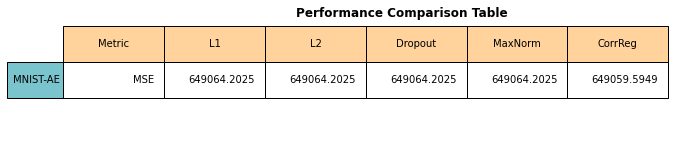

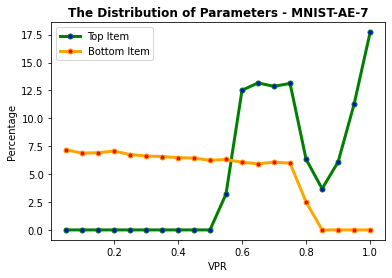

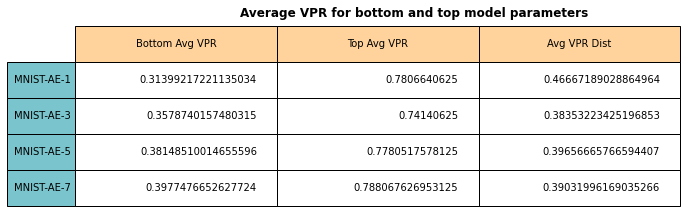

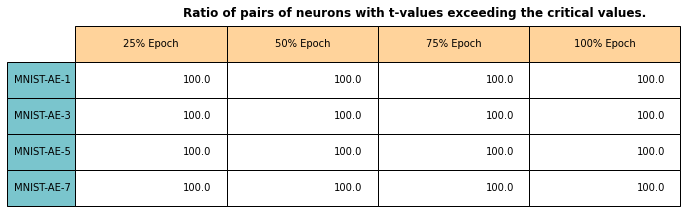

In [97]:
# Autoencoder Results Dictionary 
ae_mnist_metrics =  {
    "L1" : 0,
    "L2" : 0,
    "Dropout" : 0,
    "MaxNorm" : 0,
    "CorrReg" : 0
}

# Hyperparameter of Autoencoder Training
num_epochs = 20
learning_rate = 0.1
lambda_reg = 1e-4
beta_reg = 1e-6
maxnorm_maximum_val = 1
drop_out_probability = 0.6

# Regularizer Initialization & Autoencoder Initialization 
regularizer = Regularizer(lambda_reg=lambda_reg, beta_reg=beta_reg)
model = init_model(NetworkType.AE)

# Register Activation Layer 
activation_layers_names = []
for name, layer in model.named_modules():
    if 'hidden' in name: 
        layer.register_forward_hook(get_activation(name))
        activation_layers_names.append(name)

#####################################################################################################
######################### Autoencoder with CorrReg Training #########################################
#####################################################################################################

print("MNIST-AE with CorrReg network is being started...")
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_optimizer_momentum)
_, ae_mnist_metrics["CorrReg"] = train(model,optimizer, mnist_28_train_loader,
                                       mnist_28_test_loader, num_epochs, 
                                       RegularizerType.CorrReg, MetricType.Recon_Err, 
                                       regularizer, loss_type=LossType.MSELoss, 
                                       device=device, activation_names=activation_layers_names, 
                                       t_value_tested=True, vpr_tested=True)

#####################################################################################################
######################### Autoencoder with L1 Training ##############################################
#####################################################################################################

print("MNIST-AE with L1 network is being started...")
model = init_model(NetworkType.AE)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_optimizer_momentum)
_, ae_mnist_metrics["L1"] = train(model,optimizer, mnist_28_train_loader, mnist_28_test_loader,
                                  num_epochs,RegularizerType.L1, MetricType.Recon_Err, regularizer, 
                                  loss_type=LossType.MSELoss, device=device)

#####################################################################################################
######################### Autoencoder with L2 Training ##############################################
#####################################################################################################

print("MNIST-AE with L2 network is being started...")
model = init_model(NetworkType.AE)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_optimizer_momentum)
_, ae_mnist_metrics["L2"] = train(model,optimizer, mnist_28_train_loader, mnist_28_test_loader, 
                                  num_epochs,RegularizerType.L2, MetricType.Recon_Err, regularizer,
                                  loss_type=LossType.MSELoss, device=device)

#####################################################################################################
######################### Autoencoder with Dropout Training #########################################
#####################################################################################################

print("MNIST-AE with Dropout network is being started...")
model = init_model(NetworkType.AE,dropout=(True,drop_out_probability))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_optimizer_momentum)
_, ae_mnist_metrics["Dropout"] = train(model,optimizer, mnist_28_train_loader, mnist_28_test_loader,
                                       num_epochs,RegularizerType.Dropout, MetricType.Recon_Err, 
                                       regularizer, loss_type=LossType.MSELoss, device=device)

#####################################################################################################
######################### Autoencoder with MaxNorm Training #########################################
#####################################################################################################

print("MNIST-AE with MaxNorm network is being started...")
model = init_model(NetworkType.AE)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_optimizer_momentum)
_, ae_mnist_metrics["MaxNorm"] = train(model,optimizer, mnist_28_train_loader, mnist_28_test_loader, 
                                       num_epochs,RegularizerType.MaxNorm, MetricType.Recon_Err,
                                       regularizer, loss_type=LossType.MSELoss, device=device)

plot_performance_table(ae_mnist_metrics, "MNIST-AE", "MSE")

#####################################################################################################
######## Plotting the Effects of Adaptive Regularization (Table 1, Table 4, Figure 2) ###############
#####################################################################################################

layers_to_visualize = [1, 3, 5, 7]
percentage_layer_no = 7
number_of_top_item, number_of_bottom_item, avg_top_item, avg_bottom_item, dist_avg_item = regularizer.get_vpr_values(layers_to_visualize, percentage_layer_no)
t_ratio = regularizer.get_t_ratios()

model_name = "MNIST-AE-" + str(percentage_layer_no)
plot_vpr_figure(number_of_top_item, number_of_bottom_item, model_name)

plot_vpr_table(avg_top_item, avg_bottom_item, dist_avg_item, "MNIST-AE", layers_to_visualize)

plot_t_ratio_table(t_ratio, "MNIST-AE", layers_to_visualize)


### LeNet

LeNet with CorrReg network is being started...
LeNet with L1 network is being started...
LeNet with L2 network is being started...
LeNet with Dropout network is being started...
LeNet with MaxNorm network is being started...


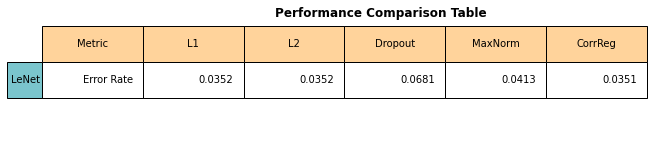

In [98]:
# LeNet Results Dictionary 
lenet_metrics =  {
    "L1" : 0,
    "L2" : 0,
    "Dropout" : 0,
    "MaxNorm" : 0,
    "CorrReg" : 0
}

# Hyperparameter of Autoencoder Training
num_epochs = 20
learning_rate = 0.001
lambda_reg = 1e-6
beta_reg = 1e-6
maxnorm_maximum_val = 1
drop_out_probability = 0.6

# Regularizer Initialization & Autoencoder Initialization 
regularizer = Regularizer(lambda_reg = lambda_reg, beta_reg = beta_reg)
model = init_model(NetworkType.LeNet, out_dim = mnist_out_size)

# Register Activation Layer 
activation_layers_names = []
for name, layer in model.named_modules():
    if 'hidden' in name: 
        layer.register_forward_hook(get_activation(name))
        activation_layers_names.append(name)
        
        
#####################################################################################################
######################### LeNet with CorrReg Training ###############################################
#####################################################################################################


print("LeNet with CorrReg network is being started...")
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, lenet_metrics["CorrReg"] = train(model, optimizer, mnist_32_train_loader, mnist_32_test_loader, num_epochs, 
                                       RegularizerType.CorrReg, MetricType.Error_Rate, 
                                       regularizer, device = device, 
                                       activation_names = activation_layers_names)

#####################################################################################################
######################### LeNet with L1 Training ####################################################
#####################################################################################################


print("LeNet with L1 network is being started...")
model = init_model(NetworkType.LeNet, out_dim = mnist_out_size)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, lenet_metrics["L1"] = train(model, optimizer, mnist_32_train_loader, 
                                                   mnist_32_test_loader, num_epochs, RegularizerType.L1,
                                                   MetricType.Error_Rate,regularizer, device)


#####################################################################################################
######################### LeNet with L2 Training ####################################################
#####################################################################################################


print("LeNet with L2 network is being started...")
model = init_model(NetworkType.LeNet, out_dim = mnist_out_size)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, lenet_metrics["L2"] = train(model, optimizer, mnist_32_train_loader, 
                                                   mnist_32_test_loader, num_epochs, RegularizerType.L2
                                                   , MetricType.Error_Rate, regularizer, device)


#####################################################################################################
######################### LeNet with Dropout Training ###############################################
#####################################################################################################


print("LeNet with Dropout network is being started...")
model = init_model(NetworkType.LeNet, out_dim = mnist_out_size, dropout=(True,drop_out_probability))
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=sgd_optimizer_momentum)
_, lenet_metrics["Dropout"] = train(model, optimizer, mnist_32_train_loader, 
                                                        mnist_32_test_loader, num_epochs, RegularizerType.Dropout,
                                                        MetricType.Error_Rate,regularizer, device)



#####################################################################################################
######################### LeNet with MaxNorm Training ###############################################
#####################################################################################################

print("LeNet with MaxNorm network is being started...")
model = init_model(NetworkType.LeNet, out_dim = mnist_out_size)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, lenet_metrics["MaxNorm"] = train(model, optimizer, mnist_32_train_loader, 
                                                        mnist_32_test_loader, num_epochs, RegularizerType.MaxNorm,
                                                        MetricType.Error_Rate,regularizer, device,
                                                        maxnorm_maximum_val = maxnorm_maximum_val)


#########################################################################################################
########################### Plotting Comparison Table ###################################################
#########################################################################################################
plot_performance_table(lenet_metrics, "LeNet", "Error Rate", no_of_decimal_points_to_show = 6)


### VGG

VGG with CorrReg network is being started...
0.13539999999999996
VGG with L1 network is being started...
0.13060000000000005
VGG with L2 network is being started...
0.13460000000000005
VGG with Dropout network is being started...
0.135
VGG with MaxNorm network is being started...
0.1281


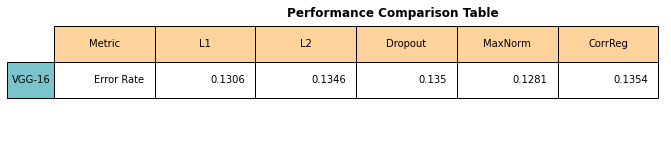

In [13]:
# VGG Results Dictionary 
vgg_metrics =  {
    "L1" : 0,
    "L2" : 0,
    "Dropout" : 0,
    "MaxNorm" : 0,
    "CorrReg" : 0
}

# Hyperparameter of Autoencoder Training
num_epochs = 2
learning_rate = 0.01
lambda_reg = 1e-4
beta_reg = 1e-6
maxnorm_maximum_val = 1
drop_out_probability = 0.6

# Regularizer Initialization & Autoencoder Initialization 
model = init_model(NetworkType.VGG)
regularizer = Regularizer(lambda_reg = lambda_reg, beta_reg = beta_reg, regularized_param_name = 'classifier')


# Register Activation Layer 
activation_layers_names = []
linear_layer_name_in_vgg = ['base_vgg.classifier.6', 'base_vgg.classifier.3', 'base_vgg.classifier.0']
for name, layer in model.named_modules():
    if name in linear_layer_name_in_vgg: 
        layer.register_forward_hook(get_activation(name))
        activation_layers_names.append(name)


#####################################################################################################
######################### VGG with CorrReg Training ################################################
#####################################################################################################


print("VGG with CorrReg network is being started...")
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
_, vgg_metrics["CorrReg"] = train(model, optimizer, cifar_10_train_loader, cifar_10_test_loader, num_epochs, 
                                       RegularizerType.CorrReg, MetricType.Error_Rate, 
                                       regularizer, device = device, 
                                       activation_names = activation_layers_names)
print(vgg_metrics["CorrReg"])


#####################################################################################################
######################### VGG with L1 Training #####################################################
#####################################################################################################


print("VGG with L1 network is being started...")    
model = init_model(NetworkType.VGG)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_optimizer_momentum)
train_history, vgg_metrics["L1"] = train(model,optimizer, cifar_10_train_loader,
                                                 cifar_10_test_loader, num_epochs,RegularizerType.L1,
                                                 MetricType.Error_Rate, regularizer, device=device)
print(vgg_metrics["L1"])


#####################################################################################################
######################### VGG with L2 Training ######################################################
#####################################################################################################


print("VGG with L2 network is being started...")    
model = init_model(NetworkType.VGG)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_optimizer_momentum)
train_history, vgg_metrics["L2"] = train(model,optimizer, cifar_10_train_loader,
                                                 cifar_10_test_loader, num_epochs,RegularizerType.L2,
                                                 MetricType.Error_Rate, regularizer, device=device)
print(vgg_metrics["L2"])


#####################################################################################################
######################### VGG with Dropout Training #################################################
#####################################################################################################


print("VGG with Dropout network is being started...")    
model = init_model(NetworkType.VGG)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_optimizer_momentum)
train_history, vgg_metrics["Dropout"] = train(model,optimizer, cifar_10_train_loader,
                                                 cifar_10_test_loader, num_epochs,RegularizerType.Dropout,
                       
                                         MetricType.Error_Rate, regularizer, device=device)
print(vgg_metrics["Dropout"])


#####################################################################################################
#########################  VGG with MaxNorm Training ################################################
#####################################################################################################

print("VGG with MaxNorm network is being started...")    
model = init_model(NetworkType.VGG)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_optimizer_momentum)
train_history, vgg_metrics["MaxNorm"] = train(model,optimizer, cifar_10_train_loader,
                                                 cifar_10_test_loader, num_epochs,RegularizerType.MaxNorm,
                                                 MetricType.Error_Rate, regularizer, device=device)
print(vgg_metrics["MaxNorm"])

#########################################################################################################
########################### Plotting Comparison Table ###################################################
#########################################################################################################
plot_performance_table(vgg_metrics, "VGG-16", "Error Rate", no_of_decimal_points_to_show = 5)


## Effectiveness of Hyperparameters

#### Polarity-LSTM

Lambda Reg: 1e-06, Beta Reg: 1e-05 -- Score = 0.6658655625536137
Lambda Reg: 0.001, Beta Reg: 1e-05 -- Score = 0.6677266785436249
Lambda Reg: 0.1, Beta Reg: 1e-05 -- Score = 0.6732960100586786
Lambda Reg: 1e-06, Beta Reg: 0.001 -- Score = 0.6736410315198245
Lambda Reg: 0.001, Beta Reg: 0.001 -- Score = 0.6840613799795671
Lambda Reg: 0.1, Beta Reg: 0.001 -- Score = 0.675897673238036
Lambda Reg: 1e-06, Beta Reg: 0.1 -- Score = 0.682910264751088
Lambda Reg: 0.001, Beta Reg: 0.1 -- Score = 0.6794495305847251
Lambda Reg: 0.1, Beta Reg: 0.1 -- Score = 0.6831045105434572
Lambda Reg: 1e-06, Beta Reg: 10 -- Score = 0.6831045105434572
Lambda Reg: 0.001, Beta Reg: 10 -- Score = 0.6831045105434572
Lambda Reg: 0.1, Beta Reg: 10 -- Score = 0.6831045105434572


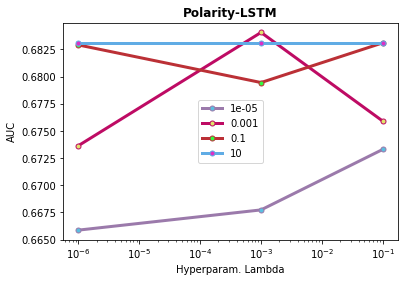

In [29]:
# Lambda & Beta values 
num_epochs = 20
beta_regs =[1e-5, 1e-3, 1e-1, 10]
lambda_regs =[1e-6, 0.001, 0.1]
learning_rate = 0.5


# Train with different Beta and Lambda Values
lstm_polarity_metric_results = []
for beta_r in beta_regs:
    results = {}
    for lambda_r in lambda_regs:
        
        # Initialize Regularizer and Models
        regularizer = Regularizer(lambda_reg = lambda_r, beta_reg = beta_r)

        model = init_model(NetworkType.LSTM, sentence_vocab_length, lstm_hidden_size, 
                           out_dim = polarity_out_size,
                           lstm_number_of_layer = lstm_number_of_layer,
                           device = device)
        
        # Register Activation Layer 
        activation_layers_names = []
        for name, layer in model.named_modules():
            if 'hidden' in name: 
                layer.register_forward_hook(get_activation(name))
                activation_layers_names.append(name)
        
        # Train the model and get metric scores
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = sgd_optimizer_momentum)
        _, metric_score = train(model,optimizer, polarity_train_loader,
                                                   polarity_test_loader, num_epochs,
                                                   RegularizerType.CorrReg, MetricType.AUC, 
                                                   regularizer, device,
                                                   activation_names = activation_layers_names)
        print("Lambda Reg: " + str(lambda_r) + ", Beta Reg: " + str(beta_r) + " -- Score = " + str(metric_score))
        results[lambda_r] = metric_score
        
        
    lstm_polarity_metric_results.append(results)
    
# Plot the Effectiveness Figure(Figure 3 in paper)
plot_effectiveness_figure(lstm_polarity_metric_results, beta_regs, "Polarity-LSTM", "AUC")